<a href="https://colab.research.google.com/github/dscohen75/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [11]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Wrangle Function

In [3]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    # If `1`, waterpump is either `non functional` or `functional needs repair`
    # If `0`, waterpump is `functional`
    train['needs_repair'] = (train['status_group'] != 'functional').astype(int)
    train.drop('status_group', axis=1, inplace=True)

    return X

In [12]:
train = wrangle(train)
test = wrangle(test)

## Split Data

In [13]:
# Split into train & validation datasets

train, val = train_test_split(train, test_size=0.2, random_state=42)

In [14]:
# Split data into target vector and feature matrix

target = 'needs_repair'
X_train = train.drop(target, axis=1)
y_train = train[target]
X_val = val.drop(target, axis=1)
y_val = val[target]

## Establish a baseline - this is a classification problem

In [15]:
print("Baseline Accuracy:", y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5429713804713805


## Build Model

In [19]:
# Make pipeline:

model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=20, max_depth=30, random_state=42, n_jobs=-1)
)

# Fit on train, score on val

model.fit(X_train, y_train);

In [20]:
print('Training accuracy score:', model.score(X_train, y_train))
print('Validation accuracy score:', model.score(X_val, y_val))

Training accuracy score: 0.9950547138047138
Validation accuracy score: 0.8191077441077441


In [21]:
y_pred = model.predict(test)

In [23]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('debbie-submission-03.csv', index=False)

from google.colab import files
files.download('debbie-submission-03.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Confusion Matrix

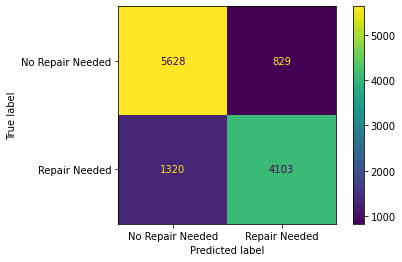

In [25]:
plot_confusion_matrix(model,
                      X_val,
                      y_val,
                      display_labels = ['No Repair Needed', 'Repair Needed'],
                      values_format='.0f');

In [26]:
print(classification_report(y_val, 
                            model.predict(X_val), 
                            target_names=['No Repair Needed', 'Repair Needed']))

                  precision    recall  f1-score   support

No Repair Needed       0.81      0.87      0.84      6457
   Repair Needed       0.83      0.76      0.79      5423

        accuracy                           0.82     11880
       macro avg       0.82      0.81      0.82     11880
    weighted avg       0.82      0.82      0.82     11880

